In [1]:
import pandas as pd

In [2]:
covid_df_full=pd.read_csv('COVID_ALL.csv')

In [3]:
covid_df_full['Date']=pd.to_datetime(covid_df_full['Date'])


In [18]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 1000000;

<IPython.core.display.Javascript object>

# SIR Model Curve fore different countries

In [5]:
from scipy.integrate import odeint
%matplotlib inline
import urllib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from typing import Dict, List
sns.set_context("talk", font_scale=1.4)
sns.set_style("whitegrid")

In [6]:
def sir_model(y,t, N, beta, gamma):
        s,i,r=y
        dSdt = -beta * s * i/ N
        dIdt = beta * s* i/N - gamma * i
        dRdt = gamma * i
        return dSdt, dIdt, dRdt

In [7]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np


In [8]:
ld_dict={
    'United Kingdom':'2020-03-24',
    'France':'2020-03-17',
    'India':'2020-03-24',
    'Argentina':'2020-03-20',
    'Spain':'2020-03-14',
    'Poland':'2020-03-24',
    'Belgium':'2020-03-17',
    'Norway':'2020-03-12',
    'South Africa':'2020-03-26',
    'Italy':'2020-03-10',
    'Colombia':'2020-03-24',
}
def get_parameters_before_ld(country,ld_date):
    
    df=covid_df_full[(covid_df_full['Country']==country)&(covid_df_full['Date']<=ld_date)]
    #print(df)
    nT = df['Population'].unique()[0]
    df=df.sort_values('Date')
    ind=0
    df=df.fillna(0)
    df['Recovered']=df['Recovered']+df['Deaths']
    df.index=pd.to_datetime(df['Date'])
    df=df.drop('Date',1)
    #df=df.groupby('Date').agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
    idx = pd.date_range(df.index[0], df.index[-1])
    df=df.reindex(idx, method='bfill')
    df=df.reset_index()
    df=df.rename(columns={'index':'Date'})
    cases=df.Confirmed.values
    for i in range(len(df)):
        if (cases[i]!=0):
            ind=i
            break
    df=df[ind:]
    # series of infected subjects
    real_I = df["Confirmed"].values
    real_R = df['Recovered'].values
    from scipy.integrate import odeint
    def sir_model_v1(params: List[float]):
 
        # model params
        beta, gamma = params[0], params[1]

        # predicted S, I, R
        S = np.zeros(real_I.shape)
        I = np.zeros(real_I.shape)
        R = np.zeros(real_I.shape)
        #print(len(S),len(real_I),len(real_R))
        # initial conditions
        S[0] = nT - real_I[0]
        I[0] = real_I[0]
        t = np.linspace(0, len(S), len(S))
    
        
        solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
        solution = np.array(solution)  
        #print(solution.shape)
        sse_error_i = (solution[:,1] - real_I)**2
        sse_error_r = (solution[:,2] - real_R)**2

        #print(sum(sse_error_i) + sum(sse_error_r))
        return sum(sse_error_i) + sum(sse_error_r)
    
    output = minimize(sir_model_v1, [0.01, 1], method='Nelder-Mead')
    
    beta, gamma = output.x
    ##print(df)
    x0=pd.to_datetime(df['Date'].values[0])
    #print(x0)
    #print(real_I)
    return beta,gamma,nT,x0,list(real_I),list(real_R)
    

def get_parameters_after_ld(country,ld_date):
    
    df=covid_df_full[(covid_df_full['Country']==country)&(covid_df_full['Date']>ld_date)]
    #print(df)
    nT = df['Population'].unique()[0]
    df=df.sort_values('Date')
    ind=0
    df=df.fillna(0)
    df['Recovered']=df['Recovered']+df['Deaths']
    df.index=pd.to_datetime(df['Date'])
    df=df.drop('Date',1)
    #df=df.groupby('Date').agg({'Confirmed':'sum','Recovered':'sum','Deaths':'sum'})
    idx = pd.date_range(df.index[0], df.index[-1])
    df=df.reindex(idx, method='bfill')
    df=df.reset_index()
    df=df.rename(columns={'index':'Date'})
    cases=df.Confirmed.values
#     for i in range(len(df)):
#         if (cases[i]!=0):
#             ind=i
#             break
#     df=df[ind:]
    # series of infected subjects
    real_I = df["Confirmed"].values
    real_R = df['Recovered'].values
    from scipy.integrate import odeint
    def sir_model_v1(params: List[float]):
 
        # model params
        beta, gamma = params[0], params[1]

        # predicted S, I, R
        S = np.zeros(real_I.shape)
        I = np.zeros(real_I.shape)
        R = np.zeros(real_I.shape)
        #print(len(S),len(real_I),len(real_R))
        # initial conditions
        S[0] = nT - real_I[0]-real_R[0]
        I[0] = real_I[0]
        R[0]= real_R[0]
        t = np.linspace(0, len(S), len(S))
    
        
        solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
        solution = np.array(solution)  
        #print(solution.shape)
        sse_error_i = (solution[:,1] - real_I)**2
        sse_error_r = (solution[:,2] - real_R)**2

        #print(sum(sse_error_i) + sum(sse_error_r))
        return sum(sse_error_i) + sum(sse_error_r)
    
    output = minimize(sir_model_v1, [0.01, 1], method='Nelder-Mead')
    
    beta, gamma = output.x
    ##print(df)
    x0=pd.to_datetime(df['Date'].values[0])
    #print(x0)
    return beta,gamma,nT,x0,list(real_I),list(real_R)
    

def simulate_sir_model_b(beta, gamma, N: int, nT, real_I):
    # predicted S, I, R
    S = np.zeros((N, ))
    I = np.zeros((N, ))
    R = np.zeros((N, ))
    
    # initial conditions
    S[0] = nT - real_I[0]
    I[0] = real_I[0]
    t = np.linspace(0, N, N)

    solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
    solution = np.array(solution)  

    return list(solution[:,0]),list(solution[:,1]),list(solution[:,2])

def simulate_sir_model_a(beta, gamma, N: int, nT, real_I,real_R):
   
    # predicted S, I, R
    S = np.zeros((N, ))
    I = np.zeros((N, ))
    R = np.zeros((N, ))

    # initial conditions
    S[0] = nT - real_I[0]-real_R[0]
    I[0] = real_I[0]
    R[0]= real_R[0]
    t = np.linspace(0, N, N)

    solution = odeint(sir_model,[S[0],I[0],R[0]],t, args=(nT, beta, gamma))
    solution = np.array(solution)  

    return list(solution[:,0]),list(solution[:,1]),list(solution[:,2])

In [9]:

import matplotlib.ticker as ticker
import matplotlib.dates as mdates
from datetime import datetime

In [11]:
def save_plot2():
    N=600
    
    country='India'
    beta_b,gamma_b,p,N_T0,I1,R1=get_parameters_before_ld(country,pd.to_datetime(ld_dict[country]))
    beta_a,gamma_a,p,N_T1,I2,R2=get_parameters_after_ld(country,pd.to_datetime(ld_dict[country]))
    S_b, I_b, R_b = simulate_sir_model_b(beta_b, gamma_b, len(I1), p, I1)

    S_a, I_a, R_a = simulate_sir_model_a(beta_a, gamma_a, len(I2), p, I2,R2)

    I1.extend(I2)
    R1.extend(R2)
    I_b.extend(I_a)
    R_b.extend(R_a)
    S_b.extend(S_a)
    S_a_0=S_b.copy()
    I_a_0=I_b.copy()
    R_a_0=R_b.copy()

    S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_a, gamma_a, N-len(S_b), p, [I_b[-1]],[R_b[-1]])

    S_a_0.extend(S_a_1)
    I_a_0.extend(I_a_1)
    R_a_0.extend(R_a_1)
   
        
        
        
    beta_b_uae,gamma_b_uae,p_uae,N_T0_uae,I1_uae,R1_uae=get_parameters_before_ld('United Arab Emirates',pd.to_datetime('2020-04-07'))
    S_b_uae, I_b_uae, R_b_uae = simulate_sir_model_b(beta_b_uae, gamma_b_uae, len(I1_uae), p_uae, I1_uae)

    S_a_0_uae=S_b_uae.copy()
    I_a_0_uae=I_b_uae.copy()
    R_a_0_uae=R_b_uae.copy()

    S_a_1_uae, I_a_1_uae, R_a_1_uae = simulate_sir_model_a(beta_b_uae, gamma_b_uae, N-len(S_b_uae), p_uae, [I_b_uae[-1]],[R_b_uae[-1]])
    S_a_0_uae.extend(S_a_1_uae)
    I_a_0_uae.extend(I_a_1_uae)
    R_a_0_uae.extend(R_a_1_uae)
    

    axs[0,0].clear() 
    axs[0,1].clear() 
    
    # (2) plot for data
    #fig, ax1 = plt.subplots(figsize=(12, 10))

    dates = [(N_T0 + i*pd.Timedelta("24h")).date() for i in range(len(I1))]
    n = len(dates)
    
    
    model_data = pd.DataFrame(index=dates)
    fit_styles = ["orange", "m+-", "y-", "k+-"]
    model_data.loc[:, "Infected (model)"] = I_b[:n]
    model_data.loc[:, "Infected (data)"] = I1[:n]
    
    model_data.loc[:, "Recovered (model)"] = R_b[:n]
    model_data.loc[:, "Recovered (data)"] = R1[:n]
    model_data.plot(ax=axs[0,0], style=fit_styles)
    
    axs[0,0].set_title("SIR parameter extraction:{} \n Transmission Rate:{}  Recovery Rate:{}".format(country,np.round(beta_b,4),np.round(gamma_b,4)))
    axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    axs[0,0].xaxis.set_major_locator(ticker.LinearLocator(6))
    #ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x) + 'K'))
    axs[0,0].set_ylabel('$Population $')
    
    if country in ld_dict.keys():
        
        axs[0,0].axvline(ld_dict[country], color="grey", ls="--", label=f"Lock Down date: {ld_dict[country]}")
    axs[0,0].legend(loc=1, fontsize=15)
    
    
    dates = [(N_T0_uae + i*pd.Timedelta("24h")).date() for i in range(len(I1_uae))]
    n=len(dates)
    
    model_data = pd.DataFrame(index=dates)
    fit_styles = ["orange", "m+-", "y-", "k+-"]
 
    model_data.loc[:, "Infected (model)"] = I_b_uae[:n]
    model_data.loc[:, "Infected (data)"] = I1_uae[:n]
    
    model_data.loc[:, "Recovered (model)"] = R_b_uae[:n]
    model_data.loc[:, "Recovered (data)"] = R1_uae[:n]
    model_data.plot(ax=axs[0,1], style=fit_styles)
    
    axs[0,1].set_title("SIR Parameter extraction: UAE \n Transmission Rate{}  Recovery Rate{}".format(np.round(beta_b_uae,4),np.round(gamma_b_uae,4)))
    axs[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    axs[0,1].xaxis.set_major_locator(ticker.LinearLocator(6))
    #axs[0,1].set_ylabel('$Population $')
    
#     if country in ld_dict.keys():
        
#         axs[0,1].axvline(ld_dict[country], color="brown", ls="--", label=f"Lock Down date: {ld_dict[country]}")
    axs[0,1].legend(loc=1, fontsize=15)
    
    #plt.legend()
    
    ax2.clear()
    ax3.clear()
    axs[1,0].clear() 
    axs[1,1].clear() 
    
    styles = ['b','red','g','b','red','g']
    
    # (1) plot for model
    #fig, ax = plt.subplots(figsize=(15, 10))
    dates = [(N_T0 + i*pd.Timedelta("24h")).date() for i in range(N)]
    model_data = pd.DataFrame(index=dates)

    model_data.loc[:, "Susceptible "] = S_a_0
    model_data.loc[:, "Infected "] = I_a_0
    model_data.loc[:, "Recovered "] = R_a_0
    model_data.plot(ax=axs[1,0], style=styles)
    
    axs[1,0].set_title("SIR model (prediction): {}\n Transmission rate(beta):{} Recovery rate(gamma):{} \n Cases:{}".format(country,np.round(beta_a,3),np.round(gamma_a,3),np.round(int(p))))
    axs[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axs[1,0].xaxis.set_major_locator(ticker.LinearLocator(6))
    
    color = 'tab:blue'
    #ax2.set_ylabel('Fraction of Population', color=color)  # we already handled the x-label with ax1
    
    #ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    axs[1,0].yaxis.set_major_locator(ticker.LinearLocator(6))
    
    axs[1,0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{}'.format(int(x/1e6)) + 'M' ))

    #ax2.yaxis.set_major_locator(ticker.LinearLocator(6))
    ax2.get_yaxis().set_ticks([])
    
    plt.show()
    
    peak_date2 = np.argmax(I_a_0)
    
 
   
    axs[1,0].axvline(dates[peak_date2], color="r", ls="--", label=f"Peak date: {dates[peak_date2]}: {np.round(I_a_0[peak_date2]/p,4)}")
    
    axs[1,0].legend(loc=1, fontsize=15)
    
    
    
    dates = [(N_T0_uae + i*pd.Timedelta("24h")).date() for i in range(N)]
    model_data = pd.DataFrame(index=dates)

    model_data.loc[:, "Susceptible "] = S_a_0_uae
    model_data.loc[:, "Infected "] = I_a_0_uae
    model_data.loc[:, "Recovered "] = R_a_0_uae
    
    model_data.plot(ax=axs[1,1], style=styles)
    
    axs[1,1].set_title("\n\nSIR model (prediction): UAE\n Transmission rate(beta):{} Recovery rate(gamma):{} \n Cases:{}".format(np.round(beta_b_uae,3),np.round(gamma_b_uae,3),np.round(int(p_uae))))
    axs[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axs[1,1].xaxis.set_major_locator(ticker.LinearLocator(6))
    color = 'tab:blue'
    ax3.set_ylabel('Fraction of Population', color=color)  # we already handled the x-label with ax1
    
    ax3.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    axs[1,1].yaxis.set_major_locator(ticker.LinearLocator(6))
    
    axs[1,1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{}'.format(int(x/1e6)) + 'M' ))

    ax3.yaxis.set_major_locator(ticker.LinearLocator(6))
    
    #ax.set_ylabel('$People (Millions)$')
    plt.show()
    
    peak_date2 = np.argmax(I_a_0_uae)
    
 
  
    axs[1,1].axvline(dates[peak_date2], color="r", ls="--", label=f"Peak date: {dates[peak_date2]}  {np.round(I_a_0_uae[peak_date2]/p_uae,4)}")
    
    axs[1,1].legend(loc=1, fontsize=15)
    
    #figure.tight_layout(pad=3.0)
   
    plt.legend()

<IPython.core.display.Javascript object>


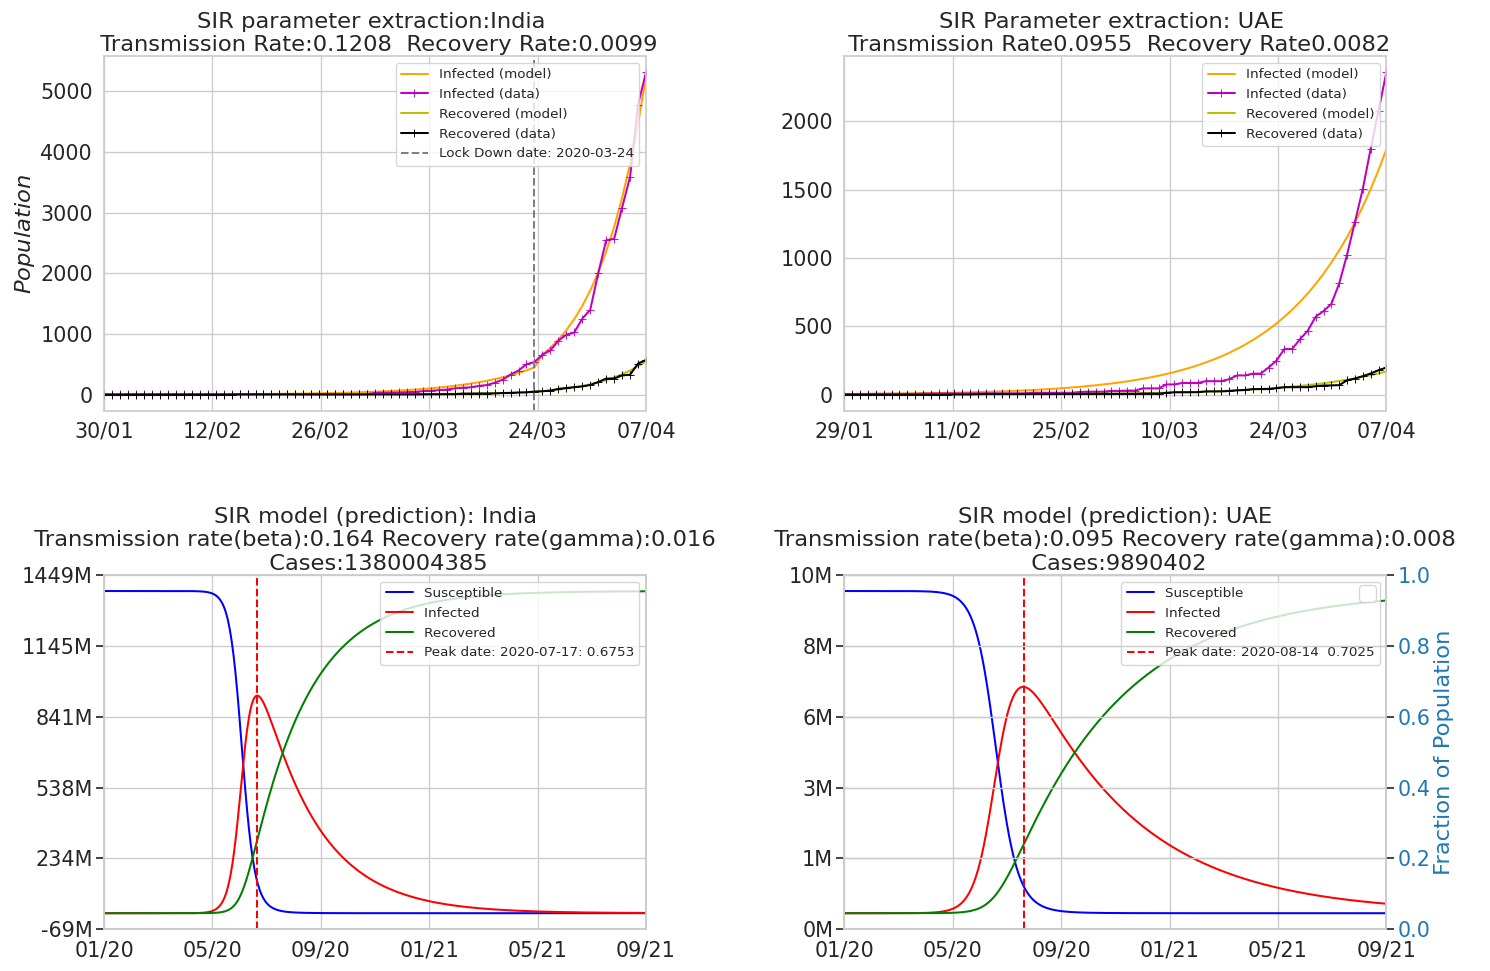

In [24]:

from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import warnings
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
import logging
logging.getLogger().setLevel(logging.CRITICAL)
from ipywidgets import Button, Layout

%matplotlib nbagg
warnings.filterwarnings("ignore",category=UserWarning)
%matplotlib nbagg
import numpy as np

# #fig, ax1 = plt.subplots(1, figsize=(15, 9))
# # fig, ax = plt.subplots(1, figsize=(15, 9),frameon=False)
#fig, (ax1, ax) = plt.subplots( 2,figsize=(13, 18))


from ipywidgets import Button, HBox, VBox

fig, axs = plt.subplots(2, 2,figsize=(23, 15))
plt.subplots_adjust( hspace=1, wspace=1)

ax2 = axs[1,0].twinx()
ax3 = axs[1,1].twinx()



def save_plot1(country,gamma_change,beta_change,country_uae,gamma_change_uae,beta_change_uae,):
    N=600
    if country in ld_dict.keys():
        
        beta_b,gamma_b,p,N_T0,I1,R1=get_parameters_before_ld(country,pd.to_datetime(ld_dict[country]))
        beta_a,gamma_a,p,N_T1,I2,R2=get_parameters_after_ld(country,pd.to_datetime(ld_dict[country]))
        S_b, I_b, R_b = simulate_sir_model_b(beta_b, gamma_b, len(I1), p, I1)
        
        S_a, I_a, R_a = simulate_sir_model_a(beta_a, gamma_a, len(I2), p, I2,R2)

        I1.extend(I2)
        R1.extend(R2)
        I_b.extend(I_a)
        R_b.extend(R_a)
        S_b.extend(S_a)
        S_a_0=S_b.copy()
        I_a_0=I_b.copy()
        R_a_0=R_b.copy()
        
        S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_change, gamma_change, N-len(S_b), p, [I_b[-1]],[R_b[-1]])

        S_a_0.extend(S_a_1)
        I_a_0.extend(I_a_1)
        R_a_0.extend(R_a_1)
    else:
        beta_b,gamma_b,p,N_T0,I1,R1=get_parameters_before_ld(country,pd.to_datetime('2020-04-07'))
        S_b, I_b, R_b = simulate_sir_model_b(beta_b, gamma_b, len(I1), p, I1)
        
        S_a_0=S_b.copy()
        I_a_0=I_b.copy()
        R_a_0=R_b.copy()
  
        S_a_1, I_a_1, R_a_1 = simulate_sir_model_a(beta_change, gamma_change, N-len(S_b), p, [I_b[-1]],[R_b[-1]])
        S_a_0.extend(S_a_1)
        I_a_0.extend(I_a_1)
        R_a_0.extend(R_a_1)
        
        
        
    beta_b_uae,gamma_b_uae,p_uae,N_T0_uae,I1_uae,R1_uae=get_parameters_before_ld('United Arab Emirates',pd.to_datetime('2020-04-07'))
    S_b_uae, I_b_uae, R_b_uae = simulate_sir_model_b(beta_b_uae, gamma_b_uae, len(I1_uae), p_uae, I1_uae)

    S_a_0_uae=S_b_uae.copy()
    I_a_0_uae=I_b_uae.copy()
    R_a_0_uae=R_b_uae.copy()

    S_a_1_uae, I_a_1_uae, R_a_1_uae = simulate_sir_model_a(beta_change_uae, gamma_change_uae, N-len(S_b_uae), p_uae, [I_b_uae[-1]],[R_b_uae[-1]])
    S_a_0_uae.extend(S_a_1_uae)
    I_a_0_uae.extend(I_a_1_uae)
    R_a_0_uae.extend(R_a_1_uae)
    

    axs[0,0].clear() 
    axs[0,1].clear() 
    
    # (2) plot for data
    #fig, ax1 = plt.subplots(figsize=(12, 10))

    dates = [(N_T0 + i*pd.Timedelta("24h")).date() for i in range(len(I1))]
    n = len(dates)
    
    
    model_data = pd.DataFrame(index=dates)
    fit_styles = ["orange", "m+-", "y-", "k+-"]
    model_data.loc[:, "Infected (model)"] = I_b[:n]
    model_data.loc[:, "Infected (data)"] = I1[:n]
    
    model_data.loc[:, "Recovered (model)"] = R_b[:n]
    model_data.loc[:, "Recovered (data)"] = R1[:n]
    model_data.plot(ax=axs[0,0], style=fit_styles)
    
    axs[0,0].set_title("SIR parameter extraction:{} \n Transmission Rate(beta):{}  Recovery rate(gamma):{}".format(country,np.round(beta_b,4),np.round(gamma_b,4)))
    axs[0,0].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    axs[0,0].xaxis.set_major_locator(ticker.LinearLocator(6))
    #ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x) + 'K'))
    axs[0,0].set_ylabel('$Population $')
    
    if country in ld_dict.keys():
        
        axs[0,0].axvline(ld_dict[country], color="grey", ls="--", label=f"Lock Down date: {ld_dict[country]}")
    axs[0,0].legend(loc=1, fontsize=15)
    
    
    dates = [(N_T0_uae + i*pd.Timedelta("24h")).date() for i in range(len(I1_uae))]
    n=len(dates)
    
    model_data = pd.DataFrame(index=dates)
    fit_styles = ["orange", "m+-", "y-", "k+-"]
 
    model_data.loc[:, "Infected (model)"] = I_b_uae[:n]
    model_data.loc[:, "Infected (data)"] = I1_uae[:n]
    
    model_data.loc[:, "Recovered (model)"] = R_b_uae[:n]
    model_data.loc[:, "Recovered (data)"] = R1_uae[:n]
    model_data.plot(ax=axs[0,1], style=fit_styles)
    
    axs[0,1].set_title("SIR Parameter extraction: UAE \n Transmission Rate(beta){}  Recovery Rate(gamma){}".format(np.round(beta_b_uae,4),np.round(gamma_b_uae,4)))
    axs[0,1].xaxis.set_major_formatter(mdates.DateFormatter('%d/%m'))
    axs[0,1].xaxis.set_major_locator(ticker.LinearLocator(6))
    #axs[0,1].set_ylabel('$Population $')
    
#     if country in ld_dict.keys():
        
#         axs[0,1].axvline(ld_dict[country], color="brown", ls="--", label=f"Lock Down date: {ld_dict[country]}")
    axs[0,1].legend(loc=1, fontsize=15)
    
    #plt.legend()
    
    ax2.clear()
    ax3.clear()
    axs[1,0].clear() 
    axs[1,1].clear() 
    
    styles = ['b','red','g','b','red','g']
    
    # (1) plot for model
    #fig, ax = plt.subplots(figsize=(15, 10))
    dates = [(N_T0 + i*pd.Timedelta("24h")).date() for i in range(N)]
    model_data = pd.DataFrame(index=dates)

    model_data.loc[:, "Susceptible "] = S_a_0
    model_data.loc[:, "Infected "] = I_a_0
    model_data.loc[:, "Recovered "] = R_a_0
    model_data.plot(ax=axs[1,0], style=styles)
    
    axs[1,0].set_title("SIR model (prediction): {}\n Transmission Rate(beta):{} Recovery Rate(gamma):{} \n Cases:{}".format(country,np.round(beta_change,3),np.round(gamma_change,3),np.round(int(p))))
    axs[1,0].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axs[1,0].xaxis.set_major_locator(ticker.LinearLocator(6))
    
    color = 'tab:blue'
    #ax2.set_ylabel('Fraction of Population', color=color)  # we already handled the x-label with ax1
    
    #ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    axs[1,0].yaxis.set_major_locator(ticker.LinearLocator(6))
    
    axs[1,0].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{}'.format(int(x/1e6)) + 'M' ))

    #ax2.yaxis.set_major_locator(ticker.LinearLocator(6))
    ax2.get_yaxis().set_ticks([])
    
    plt.show()
    
    peak_date2 = np.argmax(I_a_0)
    
 
   
    axs[1,0].axvline(dates[peak_date2], color="r", ls="--", label=f"Peak date: {dates[peak_date2]}: {np.round(I_a_0[peak_date2]/p,4)}")
    
    axs[1,0].legend(loc=1, fontsize=15)
    
    
    
    dates = [(N_T0_uae + i*pd.Timedelta("24h")).date() for i in range(N)]
    model_data = pd.DataFrame(index=dates)

    model_data.loc[:, "Susceptible "] = S_a_0_uae
    model_data.loc[:, "Infected "] = I_a_0_uae
    model_data.loc[:, "Recovered "] = R_a_0_uae
    
    model_data.plot(ax=axs[1,1], style=styles)
    
    axs[1,1].set_title("\n\nSIR model (prediction): UAE\n Transmission Rate:{} Recovery Rate:{} \n Cases:{}".format(np.round(beta_change_uae,3),np.round(gamma_change_uae,3),np.round(int(p_uae))))
    axs[1,1].xaxis.set_major_formatter(mdates.DateFormatter('%m/%y'))
    axs[1,1].xaxis.set_major_locator(ticker.LinearLocator(6))
    color = 'tab:blue'
    ax3.set_ylabel('Fraction of Population', color=color)  # we already handled the x-label with ax1
    
    ax3.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    axs[1,1].yaxis.set_major_locator(ticker.LinearLocator(6))
    
    axs[1,1].yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{}'.format(int(x/1e6)) + 'M' ))

    ax3.yaxis.set_major_locator(ticker.LinearLocator(6))
    
    #ax.set_ylabel('$People (Millions)$')
    plt.show()
    
    peak_date2 = np.argmax(I_a_0_uae)
    
 
  
    axs[1,1].axvline(dates[peak_date2], color="r", ls="--", label=f"Peak date: {dates[peak_date2]}  {np.round(I_a_0_uae[peak_date2]/p_uae,4)}")
    
    axs[1,1].legend(loc=1, fontsize=15)
    
    #figure.tight_layout(pad=3.0)
   
    plt.legend()
    
style = {'description_width': 'initial'}
country=widgets.Dropdown(
    options=covid_df_full.Country.unique(),
    value='India',
    description='COUNTRY',
    disabled=False,
)
country_uae=widgets.Dropdown(
    options=['UAE'],
    value='UAE',
    description='UNITED ARAB EMIRATES',
    disabled=False,
    style=style
)



gamma_change = widgets.FloatSlider(min=0, max=1,step=0.001, value=0.016, description='recovery rate(gamma)',style = style)
beta_change = widgets.FloatSlider(min=0, max=1,step=0.001, value=0.16, description='transmission rate(beta):',style = style)

gamma_change_uae = widgets.FloatSlider(min=0, max=1,step=0.001, value=0.008, description='recovery rate(gamma)',style = style)
beta_change_uae = widgets.FloatSlider(min=0, max=1,step=0.001, value=0.09, description='transmission rate(beta):',style = style)


def update_x_range(*args):
    #print(country.value)
    if country.value in ld_dict.keys():

        beta_a,gamma_a,p,N_T1,I2,R2=get_parameters_after_ld(country.value,pd.to_datetime(ld_dict[country.value]))
    
    else:
         
        beta_a,gamma_a,p,N_T0,I1,R1=get_parameters_before_ld(country.value,pd.to_datetime('2020-04-07'))
    beta_b_uae,gamma_b_uae,p_uae,N_T0_uae,I1_uae,R1_uae=get_parameters_before_ld('United Arab Emirates',pd.to_datetime('2020-04-07'))
  
        #print("dd")
    
    gamma_change.value=gamma_a
    
    beta_change.value=beta_a
    gamma_change_uae.value=gamma_b_uae
    beta_change_uae.value=beta_b_uae
    
def update_x_range_uae(*args):  
    #beta_b_uae,gamma_b_uae,p_uae,N_T0_uae,I1_uae,R1_uae=get_parameters_before_ld('United Arab Emirates',pd.to_datetime('2020-04-07'))
  
    gamma_change_uae.value=gamma_change.value
    beta_change_uae.value=beta_change.value

country.observe(update_x_range, 'value')
#country_uae.observe(update_x_range_uae, 'value')

button = widgets.Button(description="Reset Filter",layout=Layout( height='50px'),style= {'button_color':'skyblue'})

output = widgets.Output()

button2 = widgets.Button(description="Apply to UAE",layout=Layout( height='50px'),style= {'button_color':'powderblue'})

# first_line = HBox([country, gamma_change])
# second_line = HBox([beta_change])
# VBox([first_line, second_line])
#display(button, output)

def on_button_clicked(b):
    with output:
        
        beta_b_uae,gamma_b_uae,p_uae,N_T0_uae,I1_uae,R1_uae=get_parameters_before_ld('United Arab Emirates',pd.to_datetime('2020-04-07'))
  
        gamma_change_uae.value=gamma_b_uae
        beta_change_uae.value=beta_b_uae
        
    
from IPython.display import display, clear_output, Image
button.on_click(on_button_clicked)
button2.on_click(update_x_range_uae)
#button2.observe(update_x_range_uae, 'value')

widgets.interactive(save_plot1,country=country, gamma_change=gamma_change, beta_change=beta_change,country_uae=country_uae, gamma_change_uae=gamma_change_uae, beta_change_uae=beta_change_uae)
save_plot2()
# container1 = widgets.HBox(children=[button] )
# display(container1)
# container = widgets.HBox(children=[country, gamma_change,beta_change] )
# display(container)

# container2 = widgets.HBox([country_uae, gamma_change_uae,beta_change_uae])
# display(container2)


first_line = VBox([country, gamma_change,beta_change],margin='left')

midline=VBox([button])
midline2=VBox([button2])
second_line = VBox([country_uae, gamma_change_uae,beta_change_uae],margin='right')
HBox([first_line,midline,midline2, second_line])


<IPython.core.display.Javascript object>